In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white

In [2]:
# Load data from other notebook
gdf = pd.read_pickle('data/geodata.pkl')
df = pd.DataFrame(gdf)

In [3]:
df.columns

Index(['index', 'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'geometry',
       'dist_2_downtown', 'avg_dists'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   index            2955 non-null   int64   
 1   id               2955 non-null   int64   
 2   date             2955 non-null   object  
 3   price            2955 non-null   int64   
 4   bedrooms         2955 non-null   int64   
 5   bathrooms        2955 non-null   float64 
 6   sqft_living      2955 non-null   int64   
 7   sqft_lot         2955 non-null   int64   
 8   floors           2955 non-null   float64 
 9   waterfront       2955 non-null   float64 
 10  view             2955 non-null   float64 
 11  condition        2955 non-null   int64   
 12  grade            2955 non-null   int64   
 13  sqft_above       2955 non-null   object  
 14  sqft_basement    2955 non-null   object  
 15  yr_built         2955 non-null   int64   
 16  yr_renovated     2955 non-null   float64 


In [5]:
# Clean up the data to change strings to integers and delete unnecessary columns
df['sqft_above'] = df['sqft_above'].astype('int64')
df['sqft_basement'] = df['sqft_basement'].astype('int64')
df['date'] = pd.DatetimeIndex(df['date']).month # get month from date
df = df.drop(columns=['index', 'id', 'geometry'])
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2955 non-null   int64  
 1   price            2955 non-null   int64  
 2   bedrooms         2955 non-null   int64  
 3   bathrooms        2955 non-null   float64
 4   sqft_living      2955 non-null   int64  
 5   sqft_lot         2955 non-null   int64  
 6   floors           2955 non-null   float64
 7   waterfront       2955 non-null   float64
 8   view             2955 non-null   float64
 9   condition        2955 non-null   int64  
 10  grade            2955 non-null   int64  
 11  sqft_above       2955 non-null   int64  
 12  sqft_basement    2955 non-null   int64  
 13  yr_built         2955 non-null   int64  
 14  yr_renovated     2955 non-null   float64
 15  zipcode          2955 non-null   int64  
 16  lat              2955 non-null   float64
 17  long          

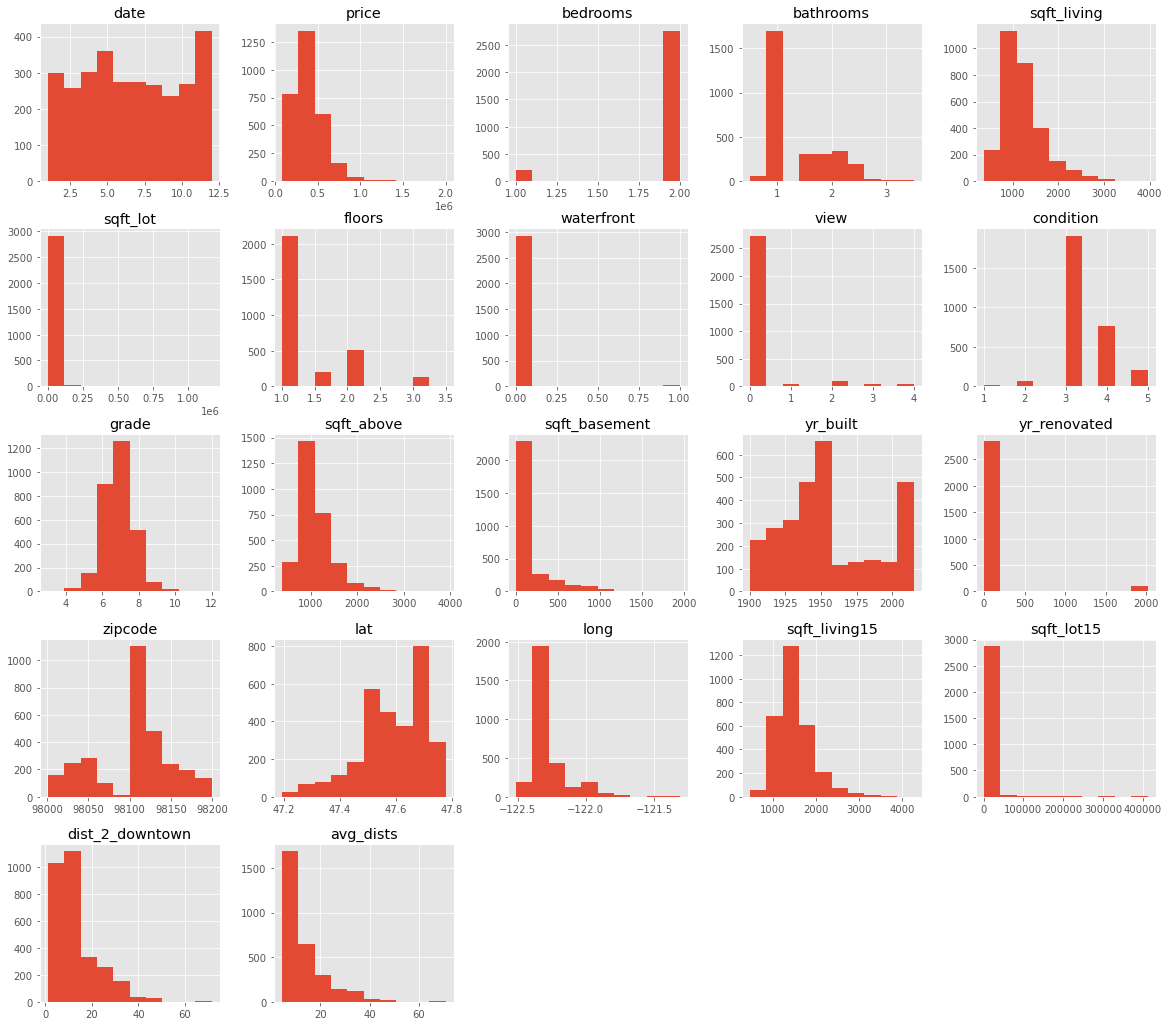

In [6]:
# Create histograms to get a sense of data
plt.style.use('ggplot')
df.hist(figsize = (20,18));

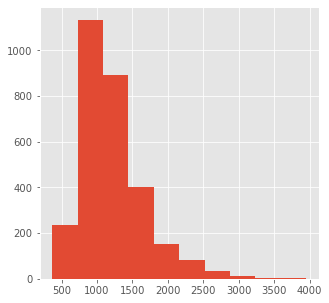

In [7]:
# Create histograms of sqft_living to get a better look
plt.style.use('ggplot')
df['sqft_living'].hist(figsize = (5,5));

['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'dist_2_downtown', 'avg_dists']


C:\Users\cm_fr\anaconda3\envs\geo\lib\site-packages\seaborn\axisgrid.py:1559: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


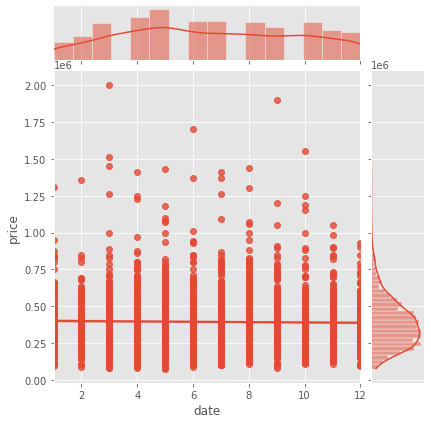

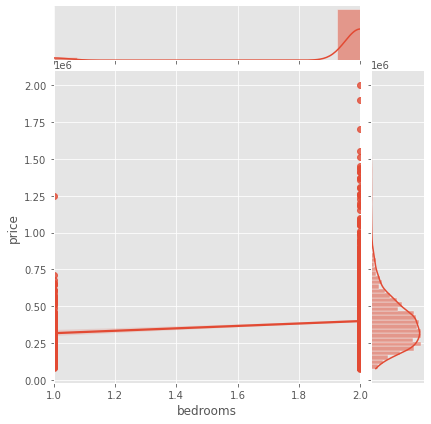

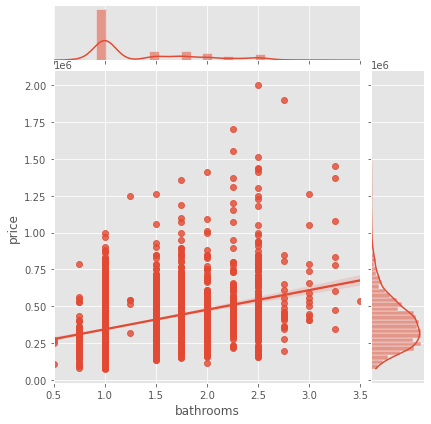

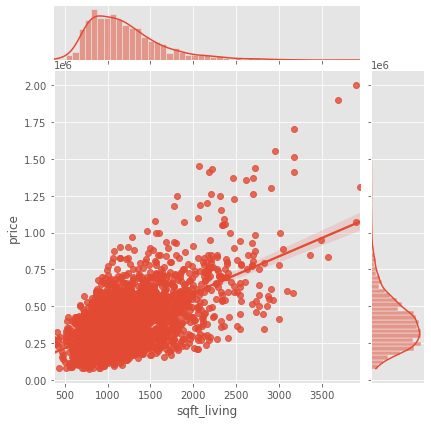

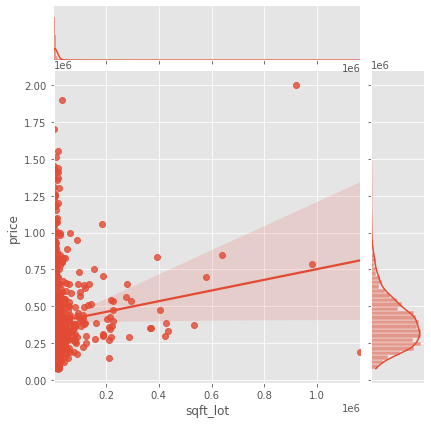

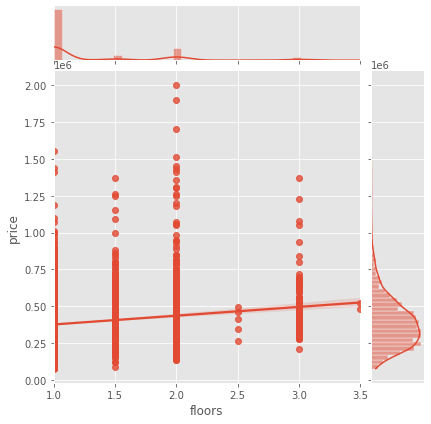

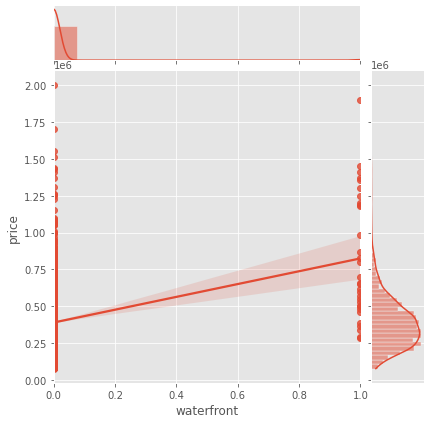

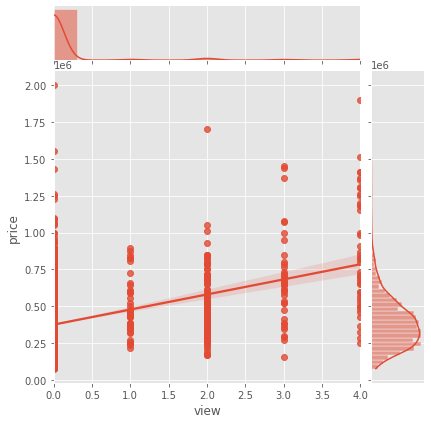

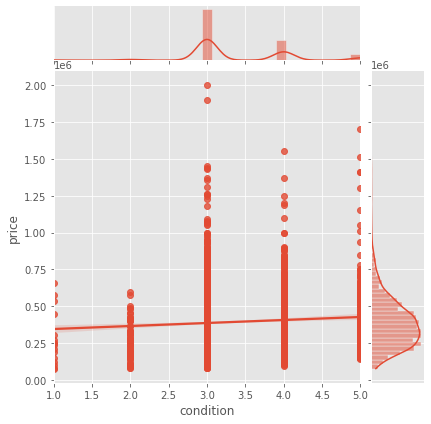

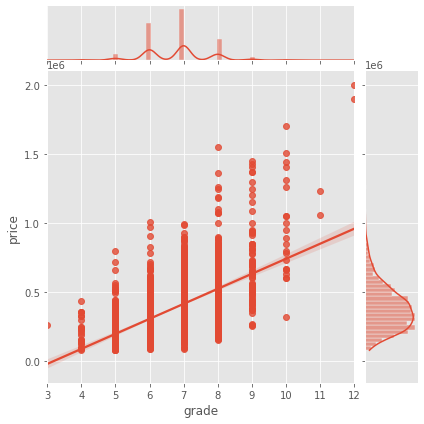

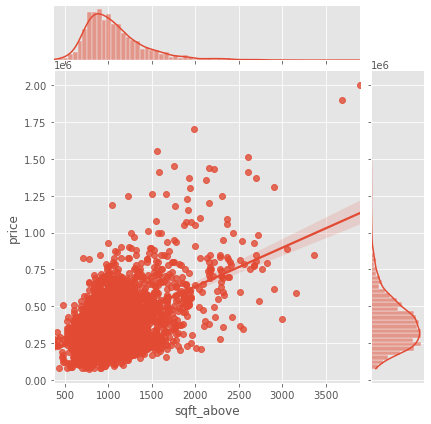

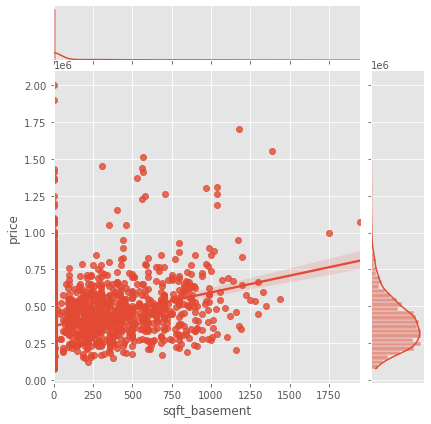

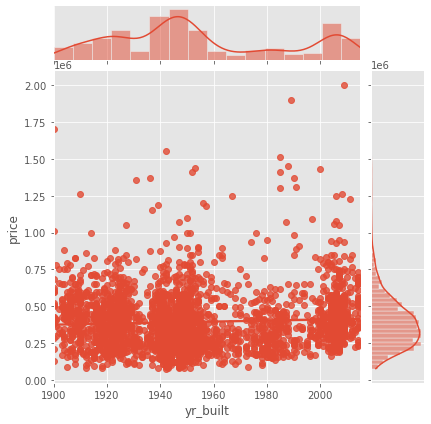

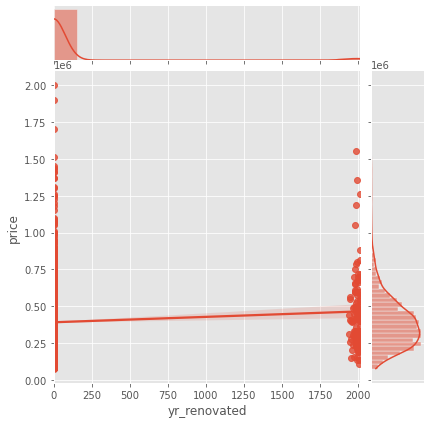

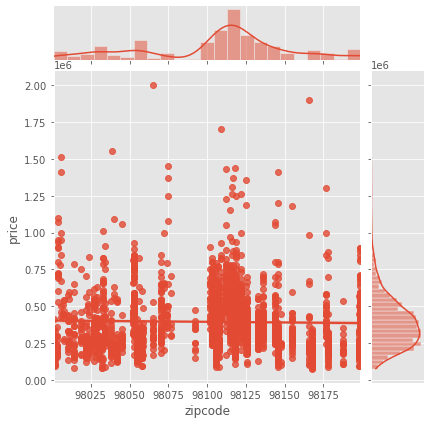

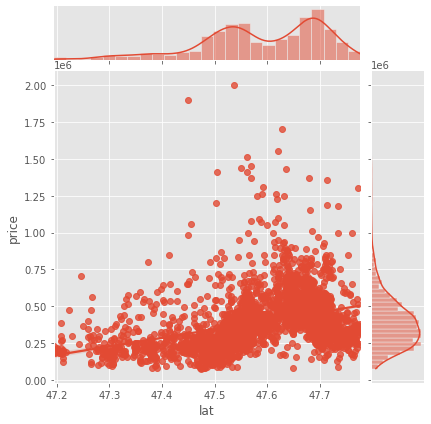

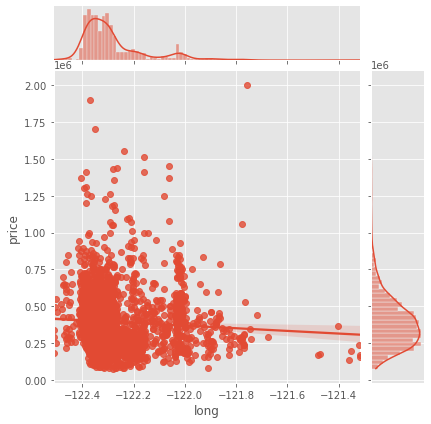

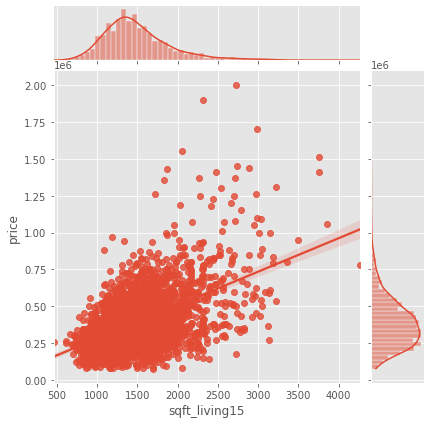

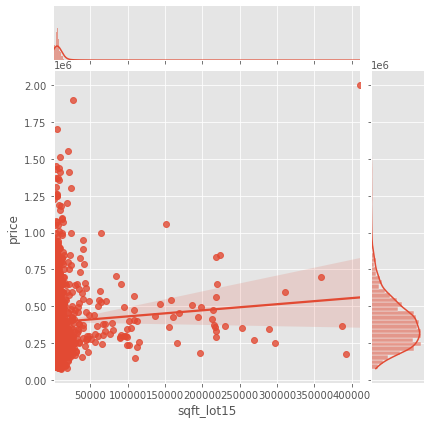

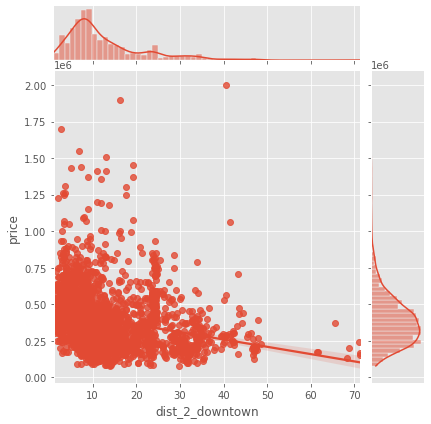

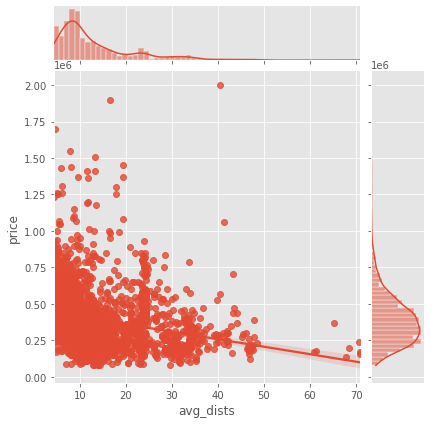

In [8]:
# look at features vs. price to get a sense what the influencers are
cols = list(df.columns)
cols.remove('price')
print(cols)
for col in cols:
    sns.jointplot(x=col, y='price', data=df, kind='reg');

<AxesSubplot:>

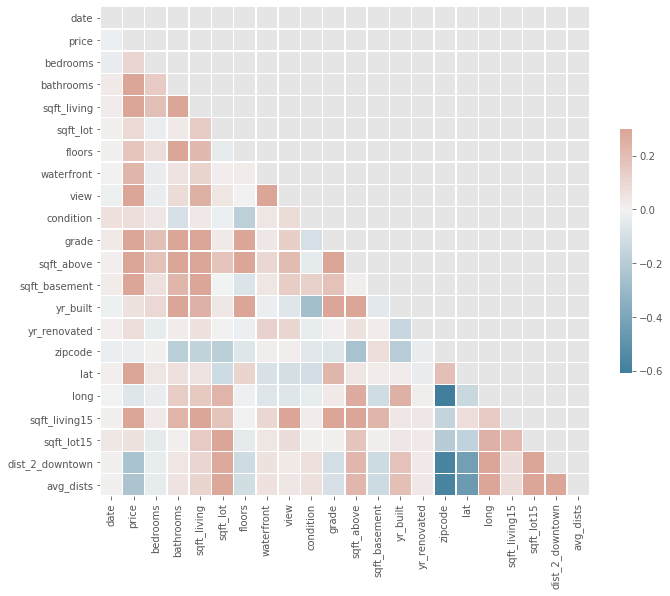

In [9]:
# Create a heatmap to identify any features with obvious multicollinearity 

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
# Drop location-related columns, leaving "dist_2_downtown"
df = df.drop(columns=['lat', 'long', 'zipcode', 'avg_dists'])

In [11]:
# Trim obvious outliers
df[(df['price'] <= 1500000) & (df['dist_2_downtown'] <= 50)].reset_index()

,index,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,dist_2_downtown
0,0,2,180000,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0,1933,0.0,2720,8062,15.348
1,1,5,468000,2,1.00,1160,6000,1.0,0.0,0.0,4,7,860,300,1942,0.0,1330,6000,9.207
2,2,12,189000,2,1.00,1200,9850,1.0,0.0,0.0,4,7,1200,0,1921,0.0,1060,5095,31.490
3,3,5,252700,2,1.50,1070,9643,1.0,0.0,0.0,3,7,1070,0,1985,0.0,1220,8386,28.271
4,4,12,280000,2,1.50,1190,1265,3.0,0.0,0.0,3,7,1190,0,2005,0.0,1390,1756,12.669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,2950,10,505000,2,2.50,1430,1201,3.0,0.0,0.0,3,8,1430,0,2009,0.0,1430,1249,7.475
2938,2951,11,414500,2,1.50,1210,1278,2.0,0.0,0.0,3,8,1020,190,2007,0.0,1210,1118,7.773
2939,2952,10,520000,2,2.25,1530,981,3.0,0.0,0.0,3,8,1480,50,2006,0.0,1530,1282,5.022
2940,2953,6,402101,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0,2009,0.0,1020,2007,2.679


<AxesSubplot:>

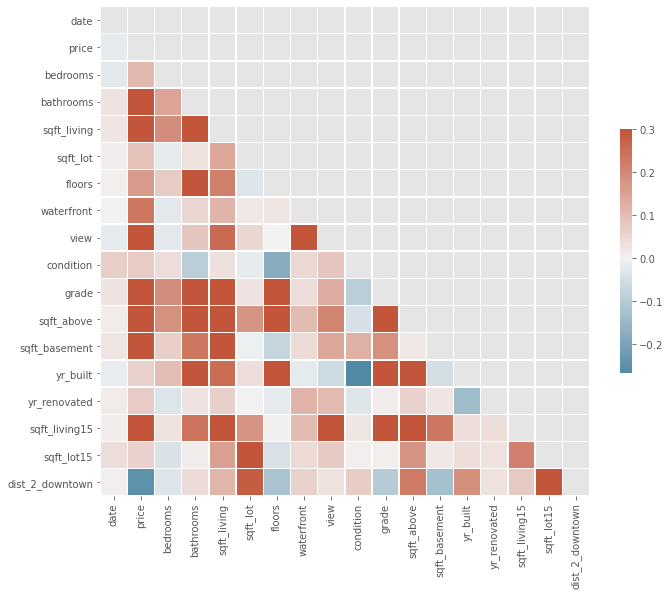

In [12]:
# Check heatmap again
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
# First Model 
outcome = 'price' # dependent variable
x_cols = list(df.columns[2:])
x_cols.append('date')# independence variables --> everything except price
print((x_cols))
# Fitting the actual model using OLS
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'dist_2_downtown', 'date']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     280.2
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:38:15   Log-Likelihood:                -38671.
No. Observations:                2955   AIC:                         7.738e+04
Df Residuals:                    2937   BIC:                         7.749e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         1.37e+06   2.06e+05      6.653      0.000    9.66e+05    1.77e+06
bedrooms        -1.419e+04   8971.257     -1.581      0.114   -3.18e+04    3403.123
bathrooms        2.364e+04   6337.707      3.730      0.000    1.12e+04    3.61e+04
sqft_living        99.8358     48.896      2.042      0.041       3.962     195.710
sqft_lot            0.3004      0.058      5.205      0.000       0.187       0.414
floors          -1.299e+04   5824.127     -2.230      0.026   -2.44e+04   -1569.843
waterfront       2.123e+05   2.52e+04      8.420      0.000    1.63e+05    2.62e+05
view             3.056e+04   3983.074      7.672      0.000    2.27e+04    3.84e+04
condition         1.92e+04   3439.793      5.581      0.000    1.25e+04    2.59e+04
grade            6.254e+04   3483.867     17.951      0.000    5.57e+04    6.94e+04
sqft_above         47.1311     49.241      0.957      0.339     -49.419     143.681
sqft_basement     -20.1155     49.155     -0.409      0.682    -116.498      76.267
yr_built         -850.6321    109.839     -7.744      0.000   -1066.001    -635.263
yr_renovated        3.5353      5.918      0.597      0.550      -8.068      15.139
sqft_living15      80.4626      6.521     12.339      0.000      67.676      93.249
sqft_lot15          0.0427      0.106      0.402      0.687      -0.165       0.251
dist_2_downtown -6100.5962    292.038    -20.890      0.000   -6673.215   -5527.977
date            -2450.4876    690.013     -3.551      0.000   -3803.445   -1097.530
==============================================================================
Omnibus:                      413.792   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1359.832
Skew:                           0.701   Prob(JB):                    5.20e-296
Kurtosis:                       6.013   Cond. No.                     5.08e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
# Model Refinement I
# Remove unecessary features

In [15]:
# Keep columns with p-value less than 0.05
outcome = 'price' # dependent variable
x_cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition',  
          'grade',  'yr_built', 'sqft_living15', 'dist_2_downtown', 'date'] # independent variables

# Fitting the model again
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     389.9
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:38:15   Log-Likelihood:                -38688.
No. Observations:                2955   AIC:                         7.740e+04
Df Residuals:                    2942   BIC:                         7.748e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.426e+06   2.01e+05      7.091      0.000    1.03e+06    1.82e+06
bathrooms        2.273e+04   6333.000      3.589      0.000    1.03e+04    3.51e+04
floors          -5281.4152   5703.626     -0.926      0.355   -1.65e+04    5902.088
sqft_living       115.8976      7.448     15.560      0.000     101.293     130.502
sqft_lot            0.3241      0.048      6.731      0.000       0.230       0.419
waterfront       2.161e+05   2.52e+04      8.561      0.000    1.67e+05    2.66e+05
view             3.042e+04   3995.141      7.613      0.000    2.26e+04    3.82e+04
condition        1.674e+04   3415.873      4.901      0.000       1e+04    2.34e+04
grade            6.594e+04   3425.071     19.253      0.000    5.92e+04    7.27e+04
yr_built         -898.1095    107.505     -8.354      0.000   -1108.902    -687.317
sqft_living15      85.7034      6.447     13.293      0.000      73.062      98.345
dist_2_downtown -5551.4009    274.244    -20.243      0.000   -6089.130   -5013.671
date            -2444.7245    692.283     -3.531      0.000   -3802.132   -1087.317
==============================================================================
Omnibus:                      439.504   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1478.218
Skew:                           0.737   Prob(JB):                         0.00
Kurtosis:                       6.136   Cond. No.                     4.58e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# need to drop "floors" this time
outcome = 'price'
x_cols = ['bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition',  
          'grade',  'yr_built', 'sqft_living15', 'dist_2_downtown', 'date']

# Fitting the model again
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     425.3
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:38:15   Log-Likelihood:                -38689.
No. Observations:                2955   AIC:                         7.740e+04
Df Residuals:                    2943   BIC:                         7.747e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.496e+06   1.86e+05      8.029      0.000    1.13e+06    1.86e+06
bathrooms        2.115e+04   6098.350      3.468      0.001    9191.130    3.31e+04
sqft_living       116.3032      7.435     15.642      0.000     101.724     130.882
sqft_lot            0.3233      0.048      6.715      0.000       0.229       0.418
waterfront       2.153e+05   2.52e+04      8.534      0.000    1.66e+05    2.65e+05
view             3.032e+04   3993.702      7.592      0.000    2.25e+04    3.82e+04
condition        1.678e+04   3415.494      4.914      0.000    1.01e+04    2.35e+04
grade             6.57e+04   3414.887     19.239      0.000     5.9e+04    7.24e+04
yr_built         -936.5623     99.158     -9.445      0.000   -1130.989    -742.136
sqft_living15      86.2147      6.423     13.422      0.000      73.620      98.809
dist_2_downtown -5490.5062    266.236    -20.623      0.000   -6012.534   -4968.479
date            -2447.5704    692.259     -3.536      0.000   -3804.932   -1090.209
==============================================================================
Omnibus:                      439.866   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1477.938
Skew:                           0.738   Prob(JB):                         0.00
Kurtosis:                       6.135   Cond. No.                     4.24e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# Model Refinement II
# normalize and standardize features

In [18]:
# try to normalize non-normal features via box-cox transformation
non_normal = ['sqft_living', 'sqft_lot', 'sqft_living15', 'dist_2_downtown']
for feat in non_normal:
    fitted_data, fitted_lambda = stats.boxcox(df[feat]) 
    df[feat] = fitted_data

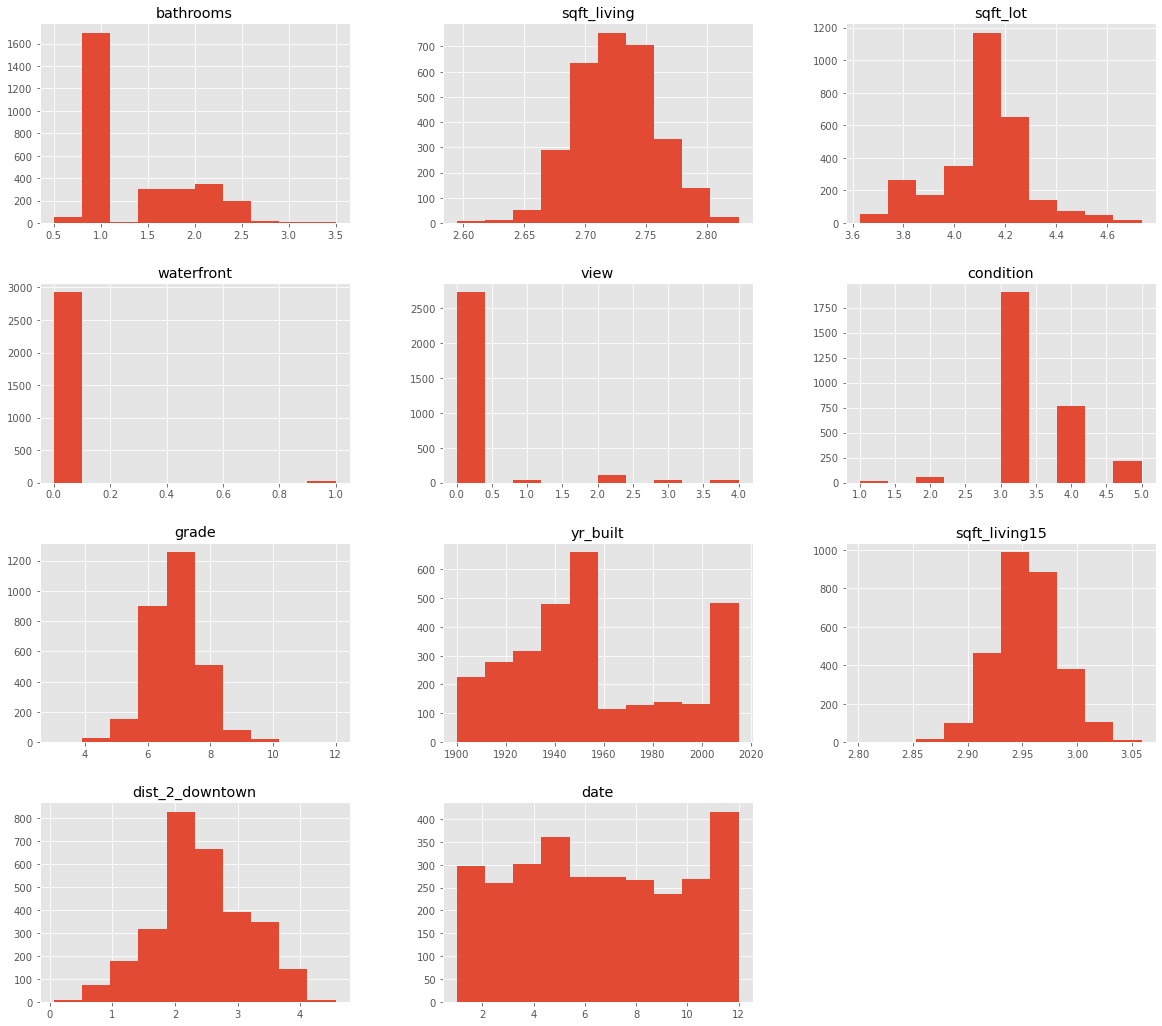

In [19]:
df[x_cols].hist(figsize = (20,18));

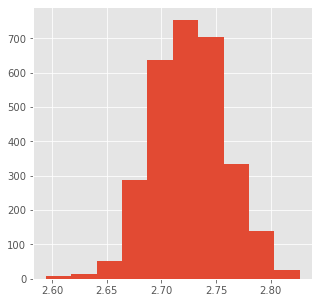

In [20]:
# Create histograms of sqft_living to get a better look
plt.style.use('ggplot')
df['sqft_living'].hist(figsize = (5,5));

In [21]:
# apply the z-score method in Pandas using the .mean() and .std() methods to standardize feature values

# copy the dataframe
df_std = df.copy()
# apply the z-score method
for column in x_cols:
    df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
# call the z_score function
df = df_std

In [22]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     395.9
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:38:18   Log-Likelihood:                -38753.
No. Observations:                2955   AIC:                         7.753e+04
Df Residuals:                    2943   BIC:                         7.760e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.949e+05   2212.373    178.495      0.000    3.91e+05    3.99e+05
bathrooms        2.232e+04   3381.513      6.600      0.000    1.57e+04    2.89e+04
sqft_living      3.446e+04   3460.357      9.958      0.000    2.77e+04    4.12e+04
sqft_lot         2.418e+04   3364.899      7.185      0.000    1.76e+04    3.08e+04
waterfront       2.205e+04   2629.772      8.386      0.000    1.69e+04    2.72e+04
view             2.531e+04   2756.396      9.184      0.000    1.99e+04    3.07e+04
condition        1.309e+04   2348.465      5.575      0.000    8488.842    1.77e+04
grade             6.93e+04   3495.800     19.823      0.000    6.24e+04    7.62e+04
yr_built        -2.645e+04   3421.957     -7.730      0.000   -3.32e+04   -1.97e+04
sqft_living15    3.496e+04   2742.348     12.749      0.000    2.96e+04    4.03e+04
dist_2_downtown -5.971e+04   3018.161    -19.783      0.000   -6.56e+04   -5.38e+04
date            -8514.4862   2221.674     -3.832      0.000   -1.29e+04   -4158.294
==============================================================================
Omnibus:                      685.455   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3596.651
Skew:                           1.002   Prob(JB):                         0.00
Kurtosis:                       8.019   Cond. No.                         3.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# Check for Multicollinearity --> want values < 5
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 2.3353840550342766),
 ('sqft_living', 2.445559021737623),
 ('sqft_lot', 2.3124919492147544),
 ('waterfront', 1.4124483621605053),
 ('view', 1.5517416117950533),
 ('condition', 1.126430138174815),
 ('grade', 2.4959132009887193),
 ('yr_built', 2.3915818257117696),
 ('sqft_living15', 1.5359655109787187),
 ('dist_2_downtown', 1.8604633795396446),
 ('date', 1.008084245232352)]

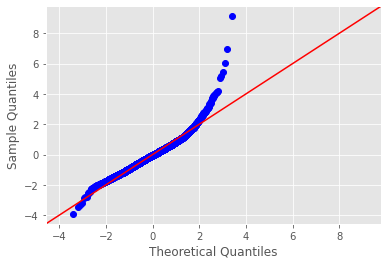

In [24]:
# Q-Q Plot to check normality of residuals
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

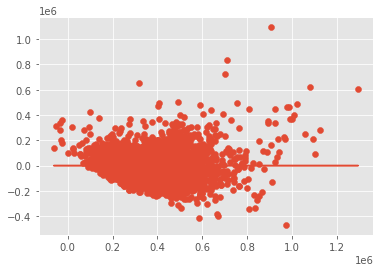

In [25]:
# Checking for Homoscedasticity
plt.scatter(model.predict(df[x_cols]), model.resid)
plt.plot(model.predict(df[x_cols]), [0 for i in range(len(df))])

In [26]:
white_test = het_white(model.resid,  model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 876.2726504950575, 'LM-Test p-value': 2.2847326076354273e-136, 'F-Statistic': 15.963162121167544, 'F-Test p-value': 3.913569199280514e-166}


In [27]:
# Model Refinement III
# Address residual normality issues and heteroscedasticity

In [28]:
# Finding a cutoff point to narrow the price range
for i in range(0, 20):
    q = i / 100
    print('{} percentile: {}'.format(q, df['price'].quantile(q=q)))

print('---')
    
for i in range(80, 100):
    q = i / 100
    print('{} percentile: {}'.format(q, df['price'].quantile(q=q)))

0.0 percentile: 78000.0
0.01 percentile: 109270.0
0.02 percentile: 124540.0
0.03 percentile: 144990.5
0.04 percentile: 155000.0
0.05 percentile: 163710.0
0.06 percentile: 174120.0
0.07 percentile: 179989.0
0.08 percentile: 187524.0
0.09 percentile: 192500.0
0.1 percentile: 199950.0
0.11 percentile: 202000.0
0.12 percentile: 208408.16
0.13 percentile: 212000.0
0.14 percentile: 216500.0
0.15 percentile: 220754.99999999997
0.16 percentile: 226512.0
0.17 percentile: 230000.0
0.18 percentile: 235000.0
0.19 percentile: 239950.0
---
0.8 percentile: 515000.0
0.81 percentile: 525000.0
0.82 percentile: 530000.0
0.83 percentile: 540000.0
0.84 percentile: 549000.0
0.85 percentile: 553000.0
0.86 percentile: 563160.0000000001
0.87 percentile: 575000.0
0.88 percentile: 582260.0
0.89 percentile: 599057.0
0.9 percentile: 605075.0
0.91 percentile: 626129.9999999994
0.92 percentile: 650000.0
0.93 percentile: 665000.0
0.94 percentile: 695000.0
0.95 percentile: 716499.9999999986
0.96 percentile: 751469.999

In [29]:
# Keep values between 1% and 90%
lower = 109270
upper = 605075

subset = df[(df['price'] >= lower) & (df['price'] <= upper)].reset_index()
print('Percent removed:',(len(df) - len(subset))/len(df))

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=subset).fit()
model.summary()

Percent removed: 0.11032148900169204


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     198.4
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:38:20   Log-Likelihood:                -33681.
No. Observations:                2629   AIC:                         6.739e+04
Df Residuals:                    2617   BIC:                         6.746e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.677e+05   1775.217    207.101      0.000    3.64e+05    3.71e+05
bathrooms        1.172e+04   2720.179      4.307      0.000    6381.653     1.7e+04
sqft_living      2.458e+04   2720.795      9.034      0.000    1.92e+04    2.99e+04
sqft_lot         6325.1069   2710.246      2.334      0.020    1010.664    1.16e+04
waterfront       1.208e+04   2939.983      4.111      0.000    6319.982    1.78e+04
view             4451.3717   2834.572      1.570      0.116   -1106.859       1e+04
condition        9573.2081   1859.675      5.148      0.000    5926.626    1.32e+04
grade            4.401e+04   2888.104     15.240      0.000    3.84e+04    4.97e+04
yr_built         -2.13e+04   2709.633     -7.862      0.000   -2.66e+04    -1.6e+04
sqft_living15    2.558e+04   2147.554     11.910      0.000    2.14e+04    2.98e+04
dist_2_downtown -4.623e+04   2365.351    -19.545      0.000   -5.09e+04   -4.16e+04
date            -4564.8015   1728.501     -2.641      0.008   -7954.169   -1175.434
==============================================================================
Omnibus:                        9.387   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.477
Skew:                           0.146   Prob(JB):                      0.00875
Kurtosis:                       2.962   Cond. No.                         3.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

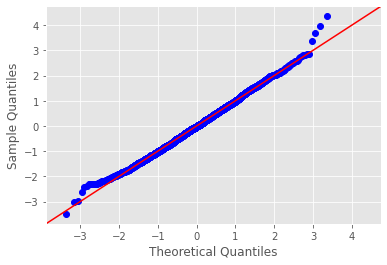

In [30]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

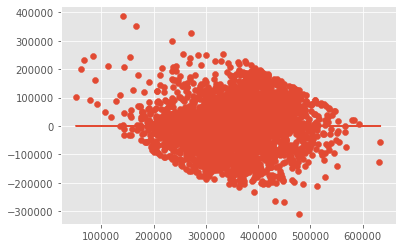

In [31]:
plt.scatter(model.predict(subset[x_cols]), model.resid)
plt.plot(model.predict(subset[x_cols]), [0 for i in range(len(subset))])

In [32]:
white_test = het_white(model.resid,  model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 285.32266762438934, 'LM-Test p-value': 5.527818979194792e-26, 'F-Statistic': 4.087949610992519, 'F-Test p-value': 6.075933533120562e-28}


In [33]:
# Model Refinement IV
# Residual normality improved but still not homoscedastic
# Try building a model from the ground up

In [34]:
outcome = 'price'

x_cols = ['grade', 'sqft_living', 'dist_2_downtown', 'waterfront']
subset = df[(df['price'] >= lower) & (df['price'] <= upper)].reset_index()
print('Percent removed:',(len(df) - len(subset))/len(df))
# subset['price'] = subset['price'].map(np.log)
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=subset).fit()
model.summary()

Percent removed: 0.11032148900169204


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     399.0
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          9.60e-269
Time:                        01:38:20   Log-Likelihood:                -33854.
No. Observations:                2629   AIC:                         6.772e+04
Df Residuals:                    2624   BIC:                         6.775e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.642e+05   1873.671    194.367      0.000    3.61e+05    3.68e+05
grade             2.84e+04   2533.560     11.210      0.000    2.34e+04    3.34e+04
sqft_living      4.358e+04   2470.423     17.639      0.000    3.87e+04    4.84e+04
dist_2_downtown -4.678e+04   1946.414    -24.033      0.000   -5.06e+04    -4.3e+04
waterfront       1.651e+04   2694.059      6.128      0.000    1.12e+04    2.18e+04
==============================================================================
Omnibus:                       36.631   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.449
Skew:                           0.242   Prob(JB):                     3.31e-08
Kurtosis:                       2.718   Cond. No.                         2.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

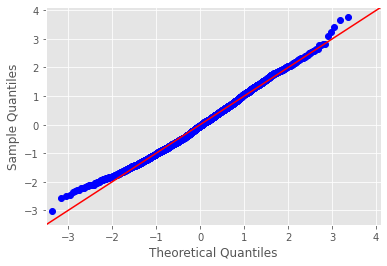

In [35]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

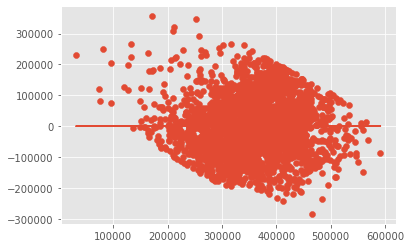

In [36]:
plt.scatter(model.predict(subset[x_cols]), model.resid)
plt.plot(model.predict(subset[x_cols]), [0 for i in range(len(subset))])

In [37]:
white_test = het_white(model.resid,  model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 18.91835463694957, 'LM-Test p-value': 0.1256569192196973, 'F-Statistic': 1.4580002908665912, 'F-Test p-value': 0.12543734591853972}


In [38]:
ypred = model.predict(X)
print(ypred)

0       259450.339020
1       380019.283149
2       298321.347142
3       291268.453849
4       361253.661936
            ...      
2950    449338.296909
2951    426249.590790
2952    484226.440510
2953    446353.837983
2954    446034.272898
Length: 2955, dtype: float64


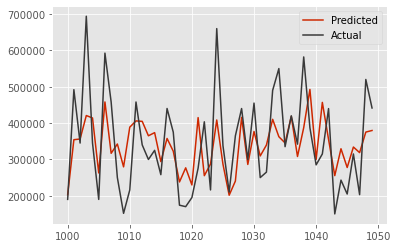

In [39]:
fig, ax = plt.subplots()
bot = 1000
top = 1050
x = ypred.index[bot:top]
y_pred = ypred[bot:top]
y_actual = df['price'][bot:top]
ax.plot(x, y_pred, color='#CE2800', label="Predicted") # predicted values
ax.plot(x, y_actual, color='#393939', label="Actual") # actual values
# ax.plot(np.hstack((x, x)), np.hstack((y_pred, y_actual)), 'r')
ax.legend(loc="best");

In [40]:
# create additional graphics
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFram
import pandas as pd
from pyproj import CRS
import matplotlib.pyplot as plt

In [41]:
def add_geo_col(df):
    # create a geometry column 
    geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]

    # Coordinate reference system : WGS84 (the GPS model for conversion)
    crs = CRS('epsg:4326')

    # Creating a Geographic data frame 
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry).reset_index()
    return gdf

In [42]:
gdf2 = pd.read_pickle('data/geodata.pkl')

In [43]:
df_top10_employers = pd.read_csv('data/top_employers.csv')
df3 = df_top10_employers[df_top10_employers['centralized_campus']=='y'].reset_index()
gdf3 = add_geo_col(df3)

In [44]:
downtown = Point(-122.3244, 47.6150)
gdf4 = gpd.GeoSeries(downtown, crs=4326)

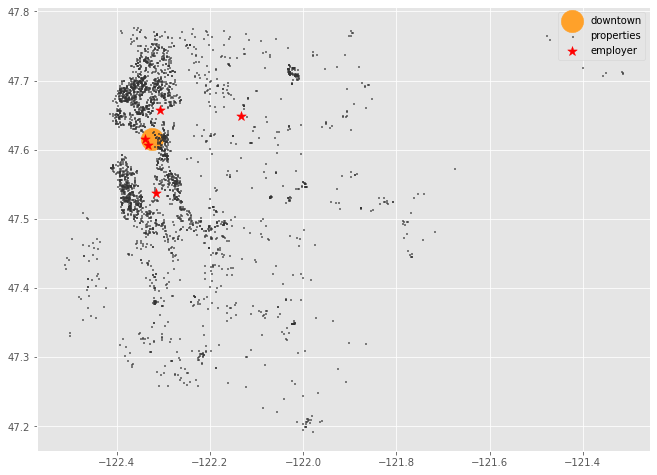

In [45]:
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(11, 20))
gdf4.plot(ax=ax, marker='o', color='#FFA12A', markersize=500, label='downtown')
gdf2.plot(ax=ax, marker='s', color='#333333', markersize=1, label='properties')
gdf3.plot(ax=ax, marker='*', color='r', markersize=100, label='employer')
ax.legend()